# Volume 4: Solitons
    Daniel Perkins
    MATH 439
    1/23/25

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft, ifft
from scipy.integrate import solve_ivp, OdeSolver
from scipy.integrate._ivp.common import warn_extraneous

In [2]:
%matplotlib notebook

# Problem 1

Write a function that accepts the time value $t$ (which won't be used here, but will be useful later) the vector $\mathbf{y}=(y_0,y_1,\ldots,y_n,y_{-n-1},\ldots,y_{-1})$ and the vector of $k$ values and returns $\mathbf{y}'$.

In [2]:
# Function for the ODE of the coefficients
def kdv_pseudospectral_ode(t, y, k):
    """
    Given the spectral coefficients y, calculates y'.
    Parameters:
        t (float): The current time
        y ((2n+2,) array): The current spectral coefficients
        k ((2n+2,) array): The vector of wavenumbers

    Returns:
        y' ((2n+2,) array): The derivative of y
    """
    # Equation 21.1
    y_prime = -(1j/2.)*k*fft(ifft(y)**2) + 1j*(k**3)*y
    return y_prime

# Problem 2

Write a function that accepts an initial condition `u0`, a final time `T`, the timestep `dt`, an integer `n` for the number of coefficients to use, and another integer `skip`.
Numerically solve for the coefficients $\mathbf{y}(t)$ of a solution to the KdV equation.

Next, convert the Fourier coefficients back into function values at the gridpoints using the inverse Fourier transform.
However, only do this for every `skip`-th timestep; we will be using far more timesteps than we want to plot.
Return the gridpoints, the timesteps, and the solution $u(x,t)$.

In [3]:
class RK4(OdeSolver):
    def __init__(self, fun, t0, y0, t_bound, dt, vectorized, **extraneous):
        super().__init__(fun, t0, y0, t_bound, vectorized, support_complex=True)

        self.dt = dt

        # t-linspace
        self.tls = np.arange(0, t_bound + dt, dt)
        
        self.idx = iter(range(1, len(self.tls)))

        warn_extraneous(extraneous)

    def _step_impl(self):
        self.y_old = self.y

        i = next(self.idx)
        t = self.tls[i]
        y = self.y
        f = self.fun
        dt = self.dt

        # RK4 algorithm
        K1 = f(t, y)
        K2 = f(t + dt / 2, y + dt * K1 / 2)
        K3 = f(t + dt / 2, y + dt * K2 / 2)
        K4 = f(t + dt, y + dt * K3)
        y_new = y + (dt / 6) * (K1 + 2 * K2 + 2 * K3 + K4)

        self.t = t
        self.y = y_new
        return True, None

    def _dense_output_impl(self):
        return lambda xs: np.interp(
            xs, (self.t_old, self.t), (self.y_old, self.y)
        )

In [47]:
def solve_kdv(u0, T, dt, n, skip):
    """
    Solve the KdV equation for x in [-pi, pi] and t in [0,T] with the given initial condition.
    
    Parameters:
        u0 - the initial conditions
        T (float) - the final time to solve until
        dt - the time step
        n - the number of points in space to use
        skip - only return every skip-th time step
    
    Returns:
        t ((n_t,) ndarray)
        x ((2n+2,) ndarray)
        u ((n_t, 2n+2) ndarray)
    """
    xs = np.linspace(-np.pi, np.pi, 2*n+2)  # Get linespace
    k = np.concatenate([np.arange(0, n+1), np.arange(-n-1, 0)])  # Define k
    initial = fft(u0(xs))  # Take fft of u
    # Find the solution
    sol = solve_ivp(kdv_pseudospectral_ode, (0, T), initial, args=(k,), 
                        method=RK4, dt=dt)
    y = sol.y.T
    t = sol.t
    u = np.real(ifft(y[::skip]))
    
    return t[::skip], xs, u

# Problem 3


Numerically solve the KdV equation on $[−π, π]$ with $n=127$ with initial
conditions
$$
u(x, t = 0) = 3s\,\mathrm{sech}^2
\left(\frac{\sqrt{s}}{2}(x + a)\right),
$$
where $s = 25^2$, $a = 2$. Solve on the time domain $[0, 0.0075]$. 
Plot the solution.
How small of a timestep did you need to use for the numerical integration to be stable?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


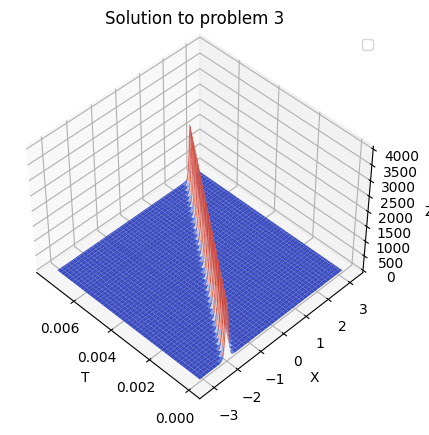

In [51]:
# Initialize variables
s = 25**2
a = 2
n = 127
def u0(xs): return 3*s*(1/np.cosh((np.sqrt(s)/2)*(xs+a)))**2
T = 0.0075
dt = 10**(-6)
skip = 4
ts, xs, u = solve_kdv(u0, T, dt, n, skip)

T, X = np.meshgrid(ts, xs)

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.plot_surface(T, X, u.T, cmap='coolwarm')
ax.view_init(elev=45, azim=-45)
ax.set_zlim(0, 4000)
ax.invert_xaxis()
ax.set_xlabel('T')
ax.set_ylabel('X')
ax.set_zlabel('Z')
ax.set_title("Solution to problem 3")

# Show plot
plt.legend()
plt.show()

In [50]:
print(f"There were {np.shape(ts)[0]} time steps.")

There were 1876 time steps


I set $dt=10^{-6}$, which resulted in 1876 timesetps. It seemed to be numerically stable there.

# Problem 4

Numerically solve the KdV equation on $[−π, π]$. This time we define the initial
condition to be the superposition of two solitons,
$$
u(x,t=0) 
= 3s_1\mathrm{sech}^2\left(\frac{\sqrt{s_1}}{2}(x+a_1)\right) 
+ 3s_2\mathrm{sech}^2\left(\frac{\sqrt{s_2}}{2}(x+a_2)\right),
$$

where $s_1 = 25^2$, $a_1 = 2$, and $s_2 = 16^2$, $a_2 = 1$.
Solve on the time domain $[0, 0.0075]$. 
Plot the solution.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


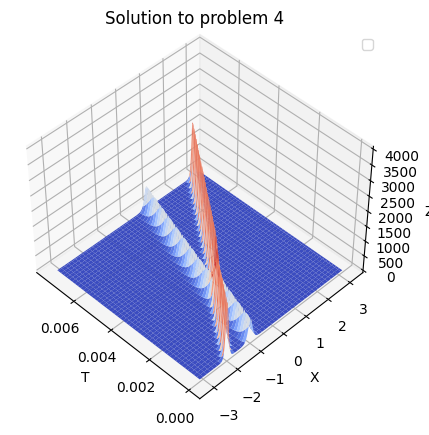

In [96]:
# Initialize variables
s1, s2 = 25**2, 16**2
a1, a2 = 2, 1
n = 127
def u0(x): 
    left = 3*s1*(1/np.cosh((np.sqrt(s1)/2)*(x+a1)))**2
    right = 3*s2*(1/np.cosh((np.sqrt(s2)/2)*(x+a2)))**2
    return left + right
T = 0.0075
dt = 10**(-6)
skip = 2
ts, xs, u = solve_kdv(u0, T, dt, n, skip)

T, X = np.meshgrid(ts, xs)

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.plot_surface(T, X, u.T, cmap='coolwarm')
ax.view_init(elev=45, azim=-45)
ax.set_zlim(0, 4000)
ax.invert_xaxis()
ax.set_xlabel('T')
ax.set_ylabel('X')
ax.set_zlabel('Z')
ax.set_title("Solution to problem 4")

# Show plot
plt.legend()
plt.show()

# Problem 5

Consider again the ODE for the spectral coefficients.
The linear term in this equation is $i\mathbf{k}^3\mathbf{y}$.
This term contributes much of the exponential growth in the ODE, and contributes to how short the time step must be to ensure numerical stability.
Make the substitution $z_k(t) = e^{-ik^3t}y_k(t)$ and find a similar ODE for $\mathbf{z}$.
This essentially allows the exponential growth to be scaled out (it's solved for analytically, replacing it with rotation in the complex plane).

Use the resulting equation to solve the previous problem.
How much larger of a timestep can you use while this method remains stable?

First we note that $z_k(t)'=-ik^3e^{-ik^3t}y_k(t)+e^{-ik^3t}y_k'(t)$ Since $y_k'(t)=-\frac{1}{2}ikF(F^{-1}(y)^2)+ik^3y$, we have $z_k(t)'=-ik^3e^{-ik^3t}y_k(t)+e^{-ik^3t}(-\frac{1}{2}ikF(F^{-1}(y)^2)+ik^3y_k(t))=-ik^3e^{-ik^3t}y_k(t)-e^{-ik^3t}\frac{1}{2}ikF(F^{-1}(y)^2)+e^{-ik^3t}ik^3y_k(t)=-e^{-ik^3t}\frac{1}{2}ikF(F^{-1}(y)^2)$. Thus, we define a new function for $z$.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


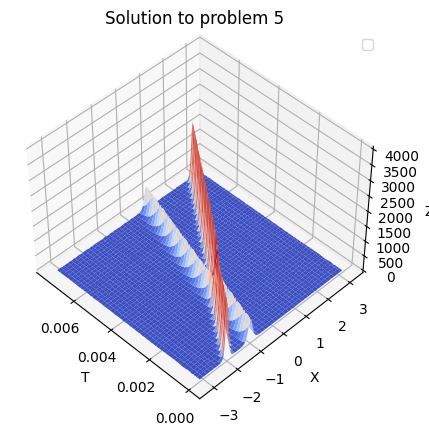

In [97]:
# Function for the ODE of the coefficients
def kdv_pseudospectral_ode2(t, z, k):
    """
    Given the spectral coefficients y, calculates y'.
    Parameters:
        t (float): The current time
        y ((2n+2,) array): The current spectral coefficients
        k ((2n+2,) array): The vector of wavenumbers

    Returns:
        y' ((2n+2,) array): The derivative of y
    """
    # Equation 21.1 but modified
    y = np.exp(1j*k**3*t)*z
    z_prime = (-1j/2.)*k*np.exp(-1j*k**3*t)*fft(ifft(y)**2)
    return z_prime

def solve_kdv2(u0, T, dt, n, skip):
    """
    Solve the KdV equation for x in [-pi, pi] and t in [0,T] with the given initial condition.
    
    Parameters:
        u0 - the initial conditions
        T (float) - the final time to solve until
        dt - the time step
        n - the number of points in space to use
        skip - only return every skip-th time step
    
    Returns:
        t ((n_t,) ndarray)
        x ((2n+2,) ndarray)
        u ((n_t, 2n+2) ndarray)
    """
    xs = np.linspace(-np.pi, np.pi, 2*n+2)  # Get linespace
    k = np.concatenate([np.arange(0, n+1), np.arange(-n-1, 0)])  # Define k
    initial = fft(u0(xs))  # Take fft of u
    # Find the solution
    sol = solve_ivp(kdv_pseudospectral_ode2, (0, T), initial, args=(k,), 
                        method=RK4, dt=dt)
    z = sol.y.T
    ts = sol.t
    y = np.array([np.exp(1j*k**3*t)*z[i] for i, t in enumerate(ts)])
    
    u = np.real(ifft(y[::skip]))
    
    return ts[::skip], xs, u

# Initialize variables
s1, s2 = 25**2, 16**2
a1, a2 = 2, 1
n = 127
def u0(x): 
    left = 3*s1*(1/np.cosh((np.sqrt(s1)/2)*(x+a1)))**2
    right = 3*s2*(1/np.cosh((np.sqrt(s2)/2)*(x+a2)))**2
    return left + right
T = 0.0075
dt = 10**(-6)*5
skip = 2
ts, xs, u = solve_kdv2(u0, T, dt, n, skip)

T, X = np.meshgrid(ts, xs)

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.plot_surface(T, X, u.T, cmap='coolwarm')
ax.view_init(elev=45, azim=-45)
ax.set_zlim(0, 4000)
ax.invert_xaxis()
ax.set_xlabel('T')
ax.set_ylabel('X')
ax.set_zlabel('Z')
ax.set_title("Solution to problem 5")

# Show plot
plt.legend()
plt.show()

This time, I was able to use a time step $5$ times as large and still maintain numerical stability. Specifally, I let $dt=5*10^{-6}$ instead of $10^{-5}$ from the previous problem.